In [1]:
import numpy as np
import itertools
import datetime

import tensorflow as tf
import sklearn as sk

from gensim.models import Word2Vec

import Functions as fn
import Iterator as it
from DS import DS
from Set import pool
from FFModel import FF_Model
from RNNModel import RNN_Model

C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [4]:
#Dataset.process_for_embedding()
#sentences = Dataset.get_sentences()
#fn.write_sentences('sentences')
sentences = fn.load_sentences('sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('W2V')
model = Word2Vec.load('W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# Layer and Index Loading

In [5]:
#word_indices, emb_layer = fn.get_index_and_emb_layer(model)
#fn.write_word_indices(word_indices, 'word_indices')
#fn.write_emb_layer(emb_layer, 'emb_layer')

word_indices = fn.load_word_indices('word_indices')
emb_layer = fn.load_emb_layer('emb_layer')

Word Indices Load Complete
Embedding Layer Load Complete


# RNN Testing

In [28]:
target = 'do'

train_cases = pool((Dataset.get_DS(stage='test', labelled='yes')).data[:-25])
validation_cases = pool(Dataset.get_DS(stage='test', labelled='yes').data[-25:])
test_cases = Dataset.get_DS(stage='train', labelled='yes')

train_cases.process_for_testing(target)
validation_cases.process_for_testing(target)
test_cases.process_for_testing(target)

In [29]:
lw, rw = 3, 3
sets = {}
sets['train_set'], sets['train_labels'], _, sets['train_lengths'] = train_cases.get_rnn_sets(word_indices, lw, rw)
sets['validation_set'], sets['validation_labels'], _, sets['validation_lengths']= validation_cases.get_rnn_sets(word_indices, lw, rw)
sets['test_set'], sets['test_labels'], sets['test_words'], sets['test_lengths'] = test_cases.get_rnn_sets(word_indices, lw, rw)

In [30]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set(sets, 0.1, seqlen=True)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.03% non-med: 0.97%
Ratio: med: 0.11% non-med: 0.89%


C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


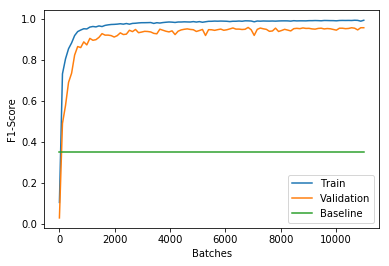

FInal Values: Tr-F1: 0.9946, Val-F1: 0.9581
Test F1-Score: 0.9216



In [31]:
RNN = RNN_Model(vocab_size=len(word_indices), state_size=100, num_classes=2, learn_rate=0.001, emb_layer=emb_layer)
RNN.build_graph()
results_list = RNN.train(sets=sets, epochs=2, batch=50, report_percentage=1, show_progress=True, show_plot=True)

In [32]:
res = RNN.predict(sets['test_set'], sets['test_lengths'])
tru = np.argmax(sets['test_labels'], 1)

In [33]:
token_perf = fn.token_perf(res, tru)

TP	TN	FP	FN
347	10755	21	38

Precision: 0.9429
Recall: 0.9013
F1-Score: 0.9216


In [34]:
baseline = [0 if word in target_dict['dosages'] else 1 for word in sets['test_words']]
sk.metrics.f1_score(tru, baseline, pos_label=0, average='binary')

0.35288414929714013

In [35]:
fn.category_words(sets['test_words'], res, tru, 1, 0)

boluses, of, three, per, third, unit, dose, dosed, for, level, less, than, <num>, dose, <num>mg, low, dose, <num>mg, uptitrated, home, dose, low, dose, <num>.<num>., mg, <num>, halved, <num>, unit, <num>, dose, of, her, normal, dose, <num>, <num>mg, ou


In [36]:
fn.colour_text(sets['test_words'], res, tru)

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [37]:
testers = Dataset.get_DS(stage='train', labelled='yes')
phrase_perf = fn.phrase_perf(target, RNN, testers, word_indices, side_words=[lw, rw], tfpn=True, show_phrases=True, case_info=True, rnn=True)

Name:  0101
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


<num> mg 16 16
<num> units 2 2
<num>-<num> tablets 1 1
insulin scale 1 0
sliding scale 2 2

Name:  0102
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


<num> liters 1 1
<num> mcg 1 1
<num> meq 1 1
<num> mg 8 7
<num> units 3 3
<num>.<num> mg 1 1
boluses of <num> mg 0 1
sliding scale 1 1

Name:  0105
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


<num> mg 6 5
<num> mg per kg 0 1
<num>.<num> mg 2 2
five units 1 1
kg subcutaneously 1 0
one unit 1 1
third unit 0 1
three 0 1
two units 1 1

Name:  0106
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


<num> mg 10 10
<num>mg 2 5
<num>mg tid 1 0
dosed for level less than <num>. 0 1
high 1 0
high dose 0 1
home dose 0 1
lantus 1 0
low dose 0 2
one 1 0
one dose 0 1
uptitrat

# HyperParameter Scan

In [ ]:
emb_sizes = [100]
emb_models = 1
target_saturations = [0.05, 0.1, 0.2, 0.5, 0.7]
layer_sizes = [50]
dropouts = [1.0]
learn_rates = [0.01]
epochs = [100]
NN_num = 5

case_num = len(emb_sizes)*emb_models*len(layer_sizes)*len(target_saturations)*len(epochs)*len(dropouts)*len(learn_rates)*NN_num
print(case_num)

In [ ]:
max_performance = 0
n = 1

for emb_size in emb_sizes:
    print('Model Number: %d/%d' %(n, case_num))
    for i in range(emb_models):
        model = Word2Vec(sentences, min_count=1, size=emb_size)
        for saturation in target_saturations:
            sets = fn.get_traintest2 (labelled_cases, model)
            fn.saturate_training_set(sets, model, target_dict['medications'], saturation)
            for layer_size in layer_sizes:
                for drop in dropouts:
                    for rate in learn_rates:
                        for epoch in epochs:
                            for j in range(NN_num):
                                print('Model Number: %d/%d' %(n, case_num))
                                print('ES: %d EM: %d sat: %f, LS: %d, drop: %f, LR: %f, epochs: %d, NN: %d' \
                                       % (emb_size, i, saturation, layer_size, drop, rate, epoch, j))
                                NN = FF_Model(input_size=emb_size, layers=[layer_size], dropout=drop, learn_rate=rate)
                                NN.build_graph()
                                NN.train(sets, epochs=epoch)
                                res = NN.predict(sets['test_set'])
                                tru = np.argmax(sets['test_labels'], 1)
                                perf = sk.metrics.f1_score(tru, res, pos_label=0)
                                if perf > max_performance:
                                    max_performance = perf
                                    NN.save_model('gold')
                                    model.save('gold/GOLDEMB')
                                NN.close()
                                n += 1